# Rešerše možností
Pro generování signálů byla potřeba zvolit vhodnou architekturu neuronové sítě generativního charakteru:
- Variational AutoEncoder **(VAE)**
- Generative Adversarial Network **(GAN)**
- Transformers **(Tr)**

Toto byly naše možnosti a objevy při rešerši, po hlubší analýze technologií a našich možností v rámci 24h Hackathonu, jsme zvolili VAE a okrajově GAN architektury.

Vyloučení Tr bylo z důvodu výpočetního výkonu a časové náročnosti učení modelů, avšak by se jednalo o nejlepší volbu pro generování dlouhých segmentů signálů.

---

# Technologie
Pro tvorbu neuronových sítí, jsme zvolili framework **TensorFlow** a konkrétně API **Keras**, pro jednoduchost a časovou omezenost, kdy jsme potřebovali málo práce a rychlé výsledky.

Alternativou k TensorFlow je **PyTorch**, který je vhodným frameworkem pro hlubší kontrolu nad sítěmi.

---

# Preprocessing
- **Scikit-Learn**
- **NumPy**
- **SciPy**

Pomocí těchto balíčků jsme různě manipulovali se signálem než jsme jej předali modelům k načení, více bude zmíněno dále.

---

# Shrnutí
## Typy sítí:
- VAE
- GAN
## Framework:
- TensorFlow - Keras
## Preprocessing
- Scikit-Learn
- Numpy
- Scipy

# Importy potřebných knihoven

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from lib.loader import SingleFileExtractor, FolderExtractor, Segment # Lokální knihovna poskytnuta k řešení
from scipy.signal import savgol_filter
import tensorflow as tf
import scipy.signal as ss
import glob

# Variational Autoencoder (VAE)

## 1. VAE

Variational Autoencoder (VAE) je generativní model, který kombinuje klasický autoencoder s bayesovským teoremem. Umožňuje rekonstruovat data a zároveň generovat nové realistické vzorky tím, že se naučí modelovat latentní distribuci vstupních dat.

Cílem není jen naučit se mapu $x \rightarrow z \rightarrow \hat{x}$, ale naučit se podmíněnou distribuci $q(z|x)$ a dekódovat z ní vzorky $z$ zpět do $x$.

---

## 2. Architektura

### 2.1 Encoder

Komprimuje vstup $x$ do latentního prostoru a generuje:

- $\mu = z\_\text{mean}$ - střed latentního rozdělení
- $\log \sigma^2 = z\_\text{logvar}$ — logaritmus rozptylu

#### Ukázka kódu:
```python
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(WINDOW_SIZE, 1))
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(2)(x) # Stride 2 - downsampling (přeskočí 2 hodnoty)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")
```

### 2.2 Sampling (reparametrizační trik)

Aby bylo možné trénovat model pomocí gradientového sestupu, použije se následující trik:

$$
z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

Místo vzorkování přímo z $\mathcal{N}(\mu, \sigma^2)$ vzorkujeme $\epsilon$ a vytvoříme $z$ deterministicky. To umožňuje propagovat gradienty skrze sampling.
(standartní sampling není diferenciabialní, tedy neumožňuje zpětnou propagaci při trénování)

#### Ukázka kódu:
```python
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
```

### 2.3 Decoder

Bere vzorek $z$ a generuje rekonstrukci $\hat{x} = p(x|z)$.

#### Ukázka kódu:
```python
def build_decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(500, activation="relu")(inputs)
    x = layers.Reshape((500, 1))(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(1, 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")
```

---

## 3. Ztrátová funkce: Evidence Lower Bound (ELBO)

Trénujeme VAE maximalizací ELBO:

$$
\log p(x) \geq \mathbb{E}_{q_\phi(z|x)} \left[ \log p_\theta(x|z) \right] - D_{\mathrm{KL}}\left( q_\phi(z|x) \,\|\, p(z) \right)
$$

### Rekonstrukční ztráta:

Odpovídá míře chyby mezi $x$ a $\hat{x}$. V praxi se často přibližuje pomocí MSE nebo Huberovy ztráty:

$$
\mathcal{L}_{\text{recon}} = \mathbb{E} \left[ ||x - \hat{x}||^2 \right]
$$

### KL divergence:

Měří, jak moc se rozdělení $q(z|x)$ liší od předpokládaného prioru $p(z) = \mathcal{N}(0, I)$:

$$
D_{\mathrm{KL}}(q(z|x) \,\|\, p(z)) = \frac{1}{2} \sum \left( \mu^2 + \sigma^2 - \log \sigma^2 - 1 \right)
$$

---

## 4. Latentní prostor

Latentní dimenze určuje, kolik „skrytých faktorů“ má model k dispozici. Čím větší latentní dimenze:

* tím větší kapacita pro modelování složitých struktur,
* ale i vyšší riziko přeučení nebo nevhodně tvarovaného latentního prostoru.

---

## 5. Chování KL divergence a optimalizační triky

### Problém:

KL divergence může být:

* příliš nízká → model „ignoruje“ latentní prostor (tzv. kolaps posterioru)
* příliš vysoká → model rekonstruuje špatně, protože latentní vektory se blíží šumu

### Řešení:

#### a) β-VAE

Zavedeme váhový parametr $\beta$:

$$
\mathcal{L}_{\text{VAE}} = \mathcal{L}_{\text{recon}} + \beta \cdot D_{\mathrm{KL}}
$$

- **$\beta > 1$** = silnější důraz na tvar latentního prostoru (větší disentanglement) — model trochu fluktuuje.
- **$\beta < 1$** = model se víc soustředí na přesnost rekonstrukce, na úkor latentního prostoru ten je poté velmi různorodý a těžko říct, co která dimenze dělá.
- **disentanglement** = schopnost modelu ovládat vlastnosti výstupu přes jednotlivé dimenze latentního vektoru. Např.: změna hodnoty jedné dimenze tohoto vektoru může vyústit ve změně amplitudy signálu.


#### b) KL annealing

Postupné zvyšování $\beta$ během tréninku:

```python
beta = min(1.0, epoch / warmup_epochs)
```

Model se nejdřív soustředí na rekonstrukci, později na tvar latentního prostoru.

#### c) Free bits

Neumožní KL divergenci spadnout pod určitou hodnotu (např. 0.5 na dimenzi), aby se zabránilo kolapsu latentu.

---

## 6. Metriky a jejich chování při tréninku

| Metrika      | Význam                                | Chování             |
| ------------ | ------------------------------------- | ------------------- |
| `recon_loss` | míra shody $x$ a $\hat{x}$            | postupně klesá      |
| `kl_loss`    | síla regularizace latentního prostoru | postupně roste      |
| `total_loss` | celková ELBO ztráta (ke minimalizaci) | kombinace dvou výše |

**Kámen úrazu:**

* Pokud `kl_loss` spadne k nule → encoder ignoruje latent
* Pokud `kl_loss` příliš roste → model generuje šum

---

## 7. Generování nových dat

Po tréninku lze vzorkovat nové latentní vektory:

$$
z \sim \mathcal{N}(0, I)
$$

a dekódovat je:

$$
\hat{x}_{\text{gen}} = \text{Decoder}(z)
$$

To umožňuje generovat nová data podobná trénovací distribuci, aniž by byla v datech obsažena.

---

## 8. Shrnutí

| Prvek         | Důležitost                                       |
| ------------- | ------------------------------------------------ |
| Sampling      | umožňuje zpětnou propagaci přes náhodnost        |
| KL divergence | tvaruje latentní prostor, nesmí být příliš nízká |
| β, annealing  | klíčové triky pro stabilní trénink               |
| Latent dim    | ovlivňuje složitost reprezentace                 |
| ELBO          | hlavní optimalizační cíl VAE                     |

In [ ]:
# Parametry
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
BATCH_SIZE = 64
LATENT_DIM = 8
EPOCHS = 10
BETA = 1e-3
MODEL_DIR = "models"
MAX_SAMPLES = 36000
os.makedirs(MODEL_DIR, exist_ok=True)

class SegmentSequence(Sequence):
    def __init__(self, segments, window_size=500, batch_size=64, normalize=True):
        self.window_size = window_size
        self.batch_size = batch_size
        self.normalize = normalize
        self.windows = []
        self.data_mean = None
        self.data_std = None

        all_data = np.concatenate([seg.data for seg in segments if seg.data is not None and len(seg.data) >= window_size])
        self.data_mean = np.nanmean(all_data)
        self.data_std = np.nanstd(all_data) + 1e-8

        for seg in segments:
            if seg.data is None or len(seg.data) < window_size:
                continue
            data = seg.data
            if normalize:
                data = (data - self.data_mean) / self.data_std
            for i in range(len(data) - window_size + 1):
                window = data[i:i + window_size]
                if np.isnan(window).any():
                    continue
                self.windows.append(window)

        self.windows = np.array(self.windows)[..., np.newaxis]

    def __len__(self):
        return len(self.windows) // self.batch_size

    def __getitem__(self, idx):
        batch = self.windows[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch, batch

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_sequence_from_single_file(file_path, annotations_path, signal_name="icp",
                                   window_size=500, batch_size=64, use_anomalous=False):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)

    good, anom = extractor.extract(signal_name)
    segments = good + anom if use_anomalous else good

    limited_segments = []
    total_samples = 0
    for seg in segments:
        if seg.data is None:
            continue
        if total_samples >= MAX_SAMPLES:
            break
        seg_length = len(seg.data)
        if total_samples + seg_length > MAX_SAMPLES:
            seg.data = seg.data[:MAX_SAMPLES - total_samples]
        limited_segments.append(seg)
        total_samples += len(seg.data)

    extractor.load_data(limited_segments)
    return SegmentSequence(limited_segments, window_size, batch_size)


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(latent_dim):
    inputs = layers.Input(shape=(WINDOW_SIZE, 1))
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(2)(x) # Stride 2 - downsampling (přeskočí 2 hodnoty)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(500, activation="relu")(inputs)
    x = layers.Reshape((500, 1))(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(1, 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer = tf.keras.optimizers.Adam(1e-3)):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)
vae = VAE(encoder, decoder, beta=BETA)
vae.compile()

last_sequence = None

all_files = get_file_paths(HDF_PATH)
if all_files:
    file_path = all_files[0]
    print(f"Trénuji na prvním souboru: {os.path.basename(file_path)}")
    sequence = load_sequence_from_single_file(
        file_path=file_path,
        annotations_path=HDF_PATH,
        signal_name=SIGNAL_NAME,
        window_size=WINDOW_SIZE,
        batch_size=BATCH_SIZE,
        use_anomalous=False
    )
    if len(sequence) > 0:
        vae.fit(sequence, epochs=EPOCHS)
        last_sequence = sequence

encoder.save(os.path.join(MODEL_DIR, "vae_encoder_2.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_2.keras"))
def plot_generation(n_samples=3):
    random_latents = tf.random.normal((n_samples, LATENT_DIM))
    generated = vae.decoder(random_latents).numpy()
    if last_sequence:
        generated = generated * last_sequence.data_std + last_sequence.data_mean

    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.plot(generated[i].squeeze())
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

def plot_reconstruction():
    if not last_sequence:
        print("Nebyla nalezena žádná trénovací sekvence.")
        return
    X, _ = last_sequence[0]
    recon = vae.decoder(vae.encoder(X)[2]).numpy()
    X = X * last_sequence.data_std + last_sequence.data_mean
    recon = recon * last_sequence.data_std + last_sequence.data_mean

    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.subplot(3, 2, i * 2 + 1)
        plt.plot(X[i].squeeze(), label="Original")
        plt.legend()
        plt.subplot(3, 2, i * 2 + 2)
        plt.plot(recon[i].squeeze(), label="Reconstruction")
        plt.legend()
    plt.tight_layout()
    plt.show()


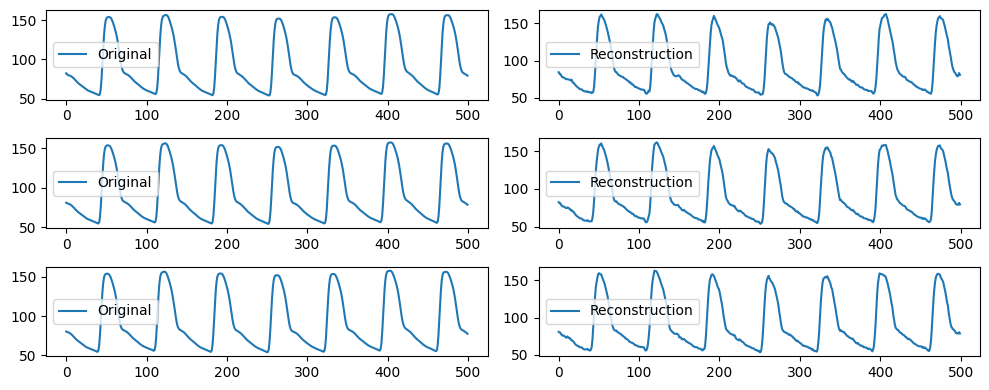

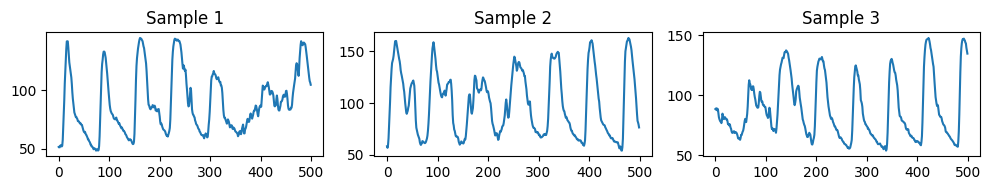

In [16]:
plot_reconstruction()
plot_generation(3)

tf.Tensor(
[[-0.96829236  0.7789972   0.3633857   1.7517349  -1.7626286   0.02698764
   1.3387693  -0.45449615]
 [-1.668366    0.8791586  -0.06188844 -0.15800053  2.6115353  -0.17844227
   0.21400012  0.18154785]
 [-0.02048288  1.468344   -0.7939734   1.2688142   0.7758253  -1.1360466
   0.21434678 -0.60265124]], shape=(3, 8), dtype=float32)


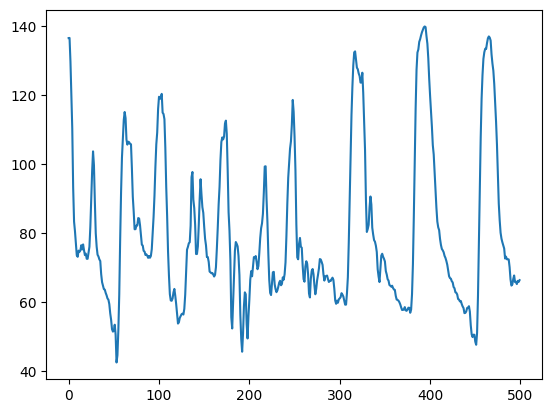

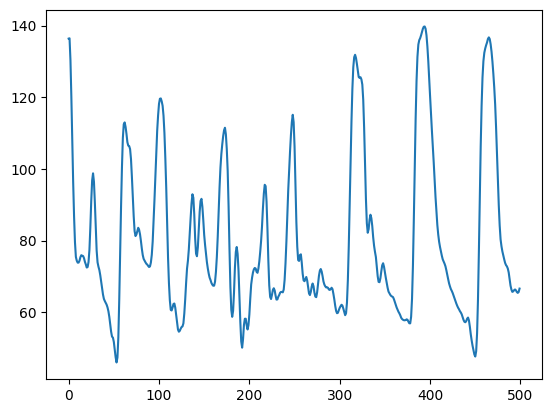

In [17]:
random_latents = tf.random.normal((3, LATENT_DIM))
generated = vae.decoder(random_latents).numpy()
generated = generated * last_sequence.data_std + last_sequence.data_mean

plt.plot(generated[0].squeeze())
plt.show()
plt.plot(savgol_filter(generated[0].squeeze(), 9, 3))
plt.show()

# Změna přístupu
Místo generování tvrdého signálu v časové doméně zkusíme generovat spektra signálů a následně tato spektra převádět zpět na skutečný signál

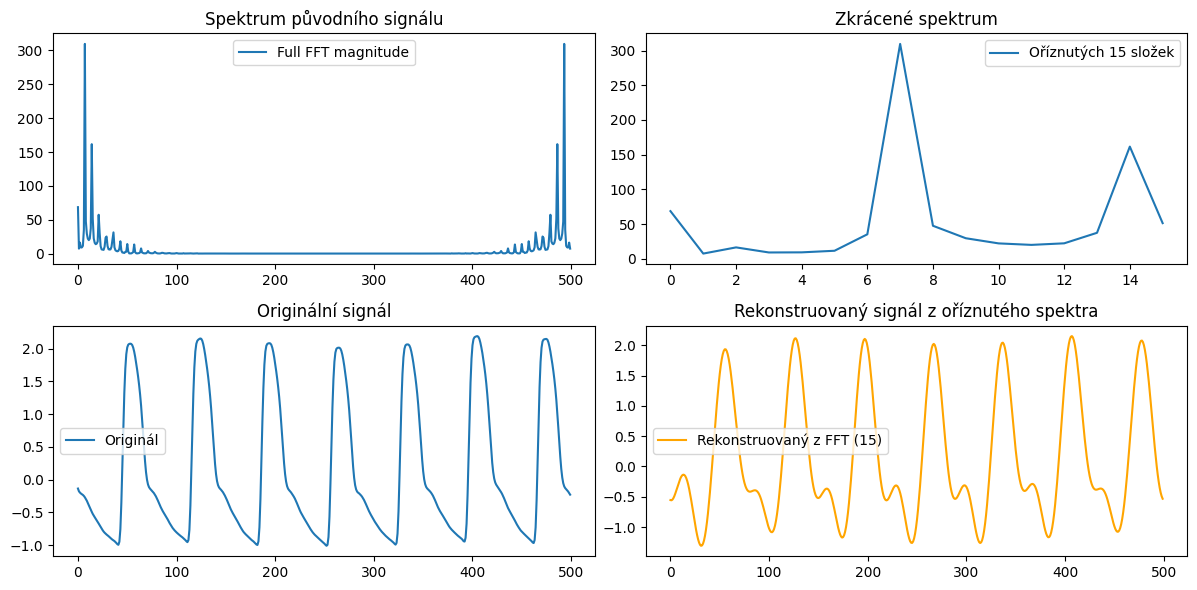

In [19]:
def reconstruct_from_partial_fft(signal, keep=25):
    """
    Vstup:
        signal - 1D pole, reálný signál
        keep - počet nízkofrekvenčních složek, které si chceme ponechat

    Výstup:
        reconstructed - rekonstruovaný signál z částečného spektra
        fft_full - původní spektrum
        fft_trimmed - oříznuté spektrum
    """
    L = len(signal)
    fft_full = np.fft.fft(signal)

    # Zachovej jen N složek (bez střední a koncové harmonické)
    fft_trimmed = fft_full[:keep].copy()

    # Zrekonstruuj symetrické spektrum (Hermitovské – pro reálný časový signál)
    fft_new = np.zeros(L, dtype=complex)
    fft_new[:keep] = fft_trimmed
    fft_new[-keep+1:] = np.conj(fft_trimmed[1:][::-1])

    reconstructed = np.fft.ifft(fft_new)
    return reconstructed.real, fft_full, fft_trimmed

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]


file_path = all_files[0]
sequence = load_sequence_from_single_file(
    file_path=file_path,
    annotations_path=HDF_PATH,
    signal_name=SIGNAL_NAME,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    use_anomalous=False
)

original_signal = sequence.windows[0].squeeze()
reconstructed, fft_full, fft_cut = reconstruct_from_partial_fft(original_signal, keep=16)

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(np.abs(fft_full), label="Full FFT magnitude")
plt.title("Spektrum původního signálu")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(np.abs(fft_cut), label="Oříznutých 15 složek")
plt.title("Zkrácené spektrum")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(original_signal, label="Originál")
plt.title("Originální signál")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(reconstructed, label="Rekonstruovaný z FFT (15)", color="orange")
plt.title("Rekonstruovaný signál z oříznutého spektra")
plt.legend()

plt.tight_layout()
plt.show()


# Zjednodušení
Pro jakési urychlení a šetření výpočetního výkonu jsme signály převedli na spektrum jednou a uložili spektra úseků signálů do .hdf5 soubor k opakovanému vyčítání

# Problém
Jednoduchá spektrální reprezentace ztrácela příliš mnoho informací o signálech, tedy v pozdějších fází jsme více experimentvoali s přípravou dat a od převodu do souboru opustili, ovšem je zbytečné neustále dokola počítat něco co stačí spočítat jednou...

Zpracovávám: TBI_001_v2_1_2_20.hdf5
Zpracovávám: TBI_001_v2_1_3_6.hdf5
Zpracovávám: TBI_002_v4_2_5_5.hdf5
Zpracovávám: TBI_002_v4_2_7_8.hdf5
Zpracovávám: TBI_003_v2_2_1_0.hdf5
Zpracovávám: TBI_003_v2_2_1_5.hdf5
Zpracovávám: TBI_004b_v2_1_2_16.hdf5
Zpracovávám: TBI_004b_v2_1_3_6.hdf5
Zpracovávám: TBI_005_v2_2_2_19.hdf5
Zpracovávám: TBI_007_v3_1_2_17.hdf5
Zpracovávám: TBI_001_v2_1_2_5.hdf5
Zpracovávám: TBI_002_v4_2_5_20.hdf5
Zpracovávám: TBI_002_v4_2_7_6.hdf5
Zpracovávám: TBI_003_v2_2_1_7.hdf5
Zpracovávám: TBI_003_v2_2_1_8.hdf5
Zpracovávám: TBI_004b_v2_1_2_4.hdf5
Zpracovávám: TBI_005_v2_2_1_12.hdf5
Zpracovávám: TBI_007_v3_1_2_23.hdf5
Zpracovávám: TBI_001_v2_3_5_10.hdf5
Zpracovávám: TBI_001_v2_4_3_16.hdf5
Zpracovávám: TBI_002_v4_2_2_2.hdf5
Zpracovávám: TBI_003_v2_2_1_6.hdf5
Zpracovávám: TBI_003_v2_2_1_9.hdf5
Zpracovávám: TBI_004b_v2_1_2_2.hdf5
Zpracovávám: TBI_004b_v2_1_2_5.hdf5
Zpracovávám: TBI_005_v2_3_3_16.hdf5
Zpracovávám: TBI_007_v3_1_2_18.hdf5
Zpracovávám: TBI_011_v2_2_1_22.hdf5
Zpr

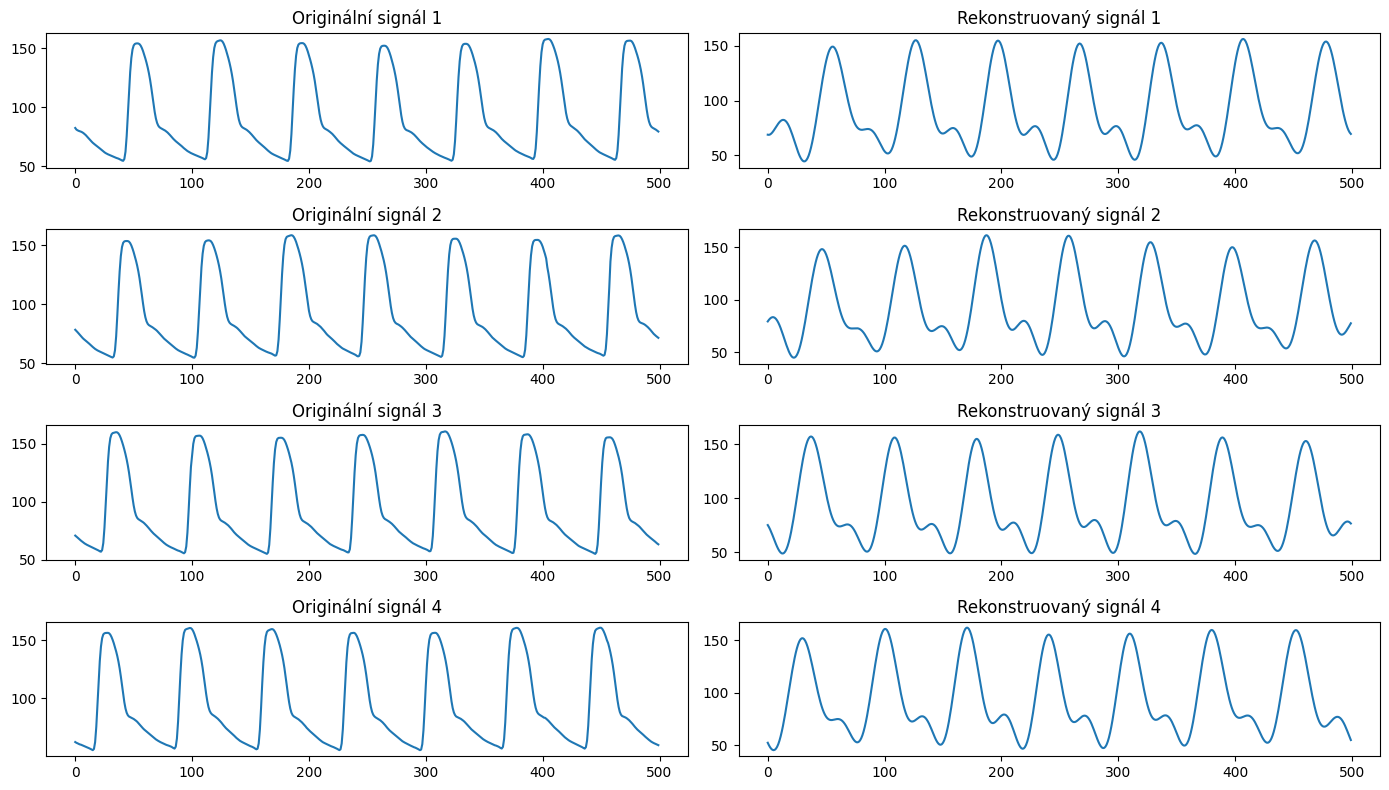

In [23]:
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
OUTPUT_HDF5 = "spectrum/spectra_analysis.hdf5"
N_COMPONENTS = 16

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    all_data = np.concatenate([seg.data for seg in segments if seg.data is not None])
    return all_data

def compute_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            fft_cut = fft_vals[:n_components].copy()
            full_spectrum = np.zeros(window_size, dtype=complex)
            full_spectrum[:n_components] = fft_cut
            full_spectrum[-n_components+1:] = np.conj(fft_cut[1:][::-1])
            spectra.append((window.copy(), full_spectrum))
    return spectra

all_files = get_file_paths(HDF_PATH)
if not all_files:
    raise FileNotFoundError("Nebyl nalezen žádný HDF5 soubor v cílové složce.")

output_dir = os.path.dirname(OUTPUT_HDF5) or "."
os.makedirs(output_dir, exist_ok=True)

with h5py.File(OUTPUT_HDF5, "w") as f:
    for file_path in all_files:
        print(f"Zpracovávám: {os.path.basename(file_path)}")
        try:
            signal = load_signal(file_path, HDF_PATH, SIGNAL_NAME)
            spectra_data = compute_spectra(signal, window_size=WINDOW_SIZE, n_components=N_COMPONENTS)
            dataset_name = os.path.splitext(os.path.basename(file_path))[0]
            original_windows = np.array([pair[0] for pair in spectra_data])
            spectra = np.array([pair[1] for pair in spectra_data])
            grp = f.create_group(dataset_name)
            grp.create_dataset("original", data=original_windows, dtype="float32")
            grp.create_dataset("spectra", data=spectra, dtype="complex64")
        except Exception as e:
            print(f"Chyba při zpracování {file_path}: {e}")

print(f"Spektrální analýza dokončena. Výsledky uloženy v {OUTPUT_HDF5}.")

def inspect_hdf5_structure(hdf5_path):
    with h5py.File(hdf5_path, "r") as f:
        print("\nStruktura HDF5 souboru:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"- Dataset: {name}, shape={obj.shape}, dtype={obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"- Group: {name}")
        f.visititems(print_structure)

        print("\nUkázka hodnot z prvního datasetu:")
        first_group = list(f.keys())[0]
        print(f"→ Group: {first_group}")
        print("Original window:", f[first_group]["original"][:1])
        print("Spectrum window:", f[first_group]["spectra"][:1])

inspect_hdf5_structure(OUTPUT_HDF5)

def reconstruct_signals_with_originals(hdf5_path, n=4):
    with h5py.File(hdf5_path, "r") as f:
        first_group = list(f.keys())[0]
        spectra = f[first_group]["spectra"][:n]
        originals = f[first_group]["original"][:n]
        print(spectra.shape, originals.shape)

    reconstructed_signals = [np.fft.ifft(spectrum).real for spectrum in spectra]

    plt.figure(figsize=(14, 8))
    for i in range(n):
        plt.subplot(n, 2, 2 * i + 1)
        plt.plot(originals[i])
        plt.title(f"Originální signál {i+1}")

        plt.subplot(n, 2, 2 * i + 2)
        plt.plot(reconstructed_signals[i])
        plt.title(f"Rekonstruovaný signál {i+1}")

    plt.tight_layout()
    plt.show()

reconstruct_signals_with_originals(OUTPUT_HDF5, n=4)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - kl_loss: 0.0209 - loss: 1.0022 - recon_loss: 1.0022
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.1118 - loss: 0.9959 - recon_loss: 0.9958


c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,recon_loss
  current = self.get_monitor_value(logs)


Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.5163 - loss: 0.9920 - recon_loss: 0.9915
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 1.8493 - loss: 0.9780 - recon_loss: 0.9761
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 4.5744 - loss: 0.9512 - recon_loss: 0.9467
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 7.7145 - loss: 0.9028 - recon_loss: 0.8950
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 10.3965 - loss: 0.8515 - recon_loss: 0.8411
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 12.1338 - loss: 0.7897 - recon_loss: 0.7776
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 13.2020 - loss: 0.7333 - recon_loss: 0.7201
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 13.5403 - loss: 0.6872 - recon_loss: 0.6737
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 13.7896 - loss: 0.6327 - recon_loss: 0.6189
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_l

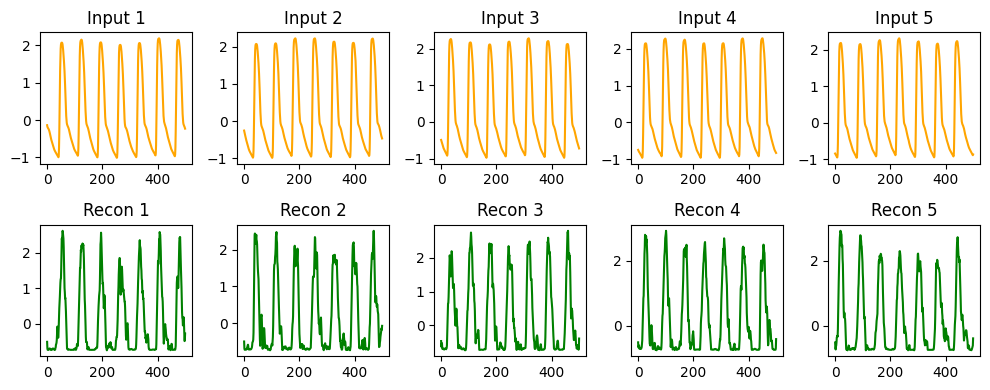

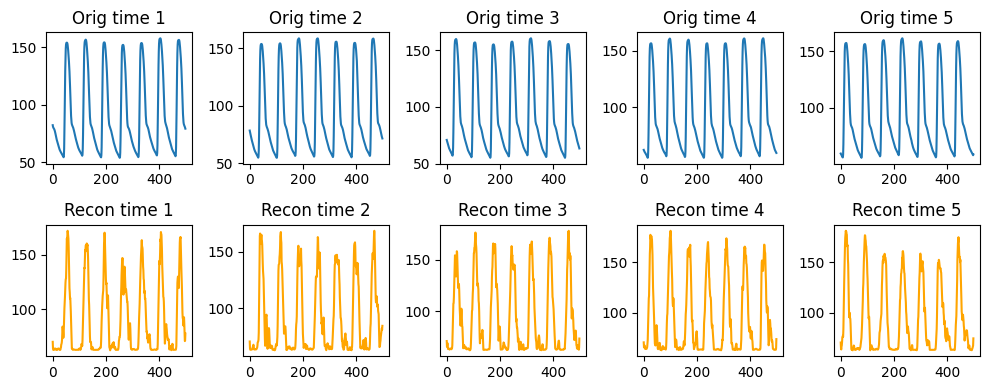

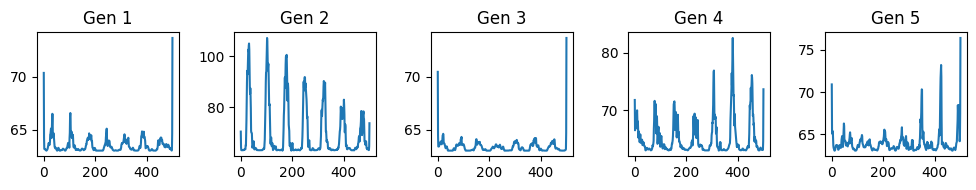

In [ ]:
HDF5_PATH = "spectrum/spectra_analysis.hdf5"
GROUP_NAME = None
LATENT_DIM = 4
EPOCHS = 50
BATCH_SIZE = 32
BETA = 1e-3

def load_spectral_data(path, group_name=None):
    with h5py.File(path, "r") as f:
        if group_name is None:
            group_name = list(f.keys())[0]
        dataset = f[group_name]
        if isinstance(dataset, h5py.Group):
            dataset = dataset[list(dataset.keys())[0]]
        spectra = dataset[:]
    return spectra

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(4, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation="relu")(inputs)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(4, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv1D(1, 3, activation="linear", padding="same")(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

spectra = load_spectral_data(HDF5_PATH, group_name=GROUP_NAME)
spectra_expanded = spectra[..., np.newaxis]  # shape (N, F) -> (N, F, 1)

scaler = StandardScaler()
data_flat = spectra_expanded.reshape(-1, 1)
data_scaled = scaler.fit_transform(data_flat).reshape(spectra_expanded.shape)

encoder = build_encoder((data_scaled.shape[1], 1), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (data_scaled.shape[1], 1))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(data_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

reconstructed = vae.decoder(vae.encoder(data_scaled)[2]).numpy()
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.plot(data_scaled[i,:,0], label="Input", color="orange")
    plt.title(f"Input {i+1}")
    plt.subplot(2, 5, i + 6)
    plt.plot(reconstructed[i,:,0], label="Recon", color="green")
    plt.title(f"Recon {i+1}")
plt.tight_layout()
plt.show()

recon_rescaled = scaler.inverse_transform(reconstructed.reshape(-1, 1)).reshape(reconstructed.shape)
original_signals = spectra[:5]
reconstructed_signals = recon_rescaled[:5, :, 0]

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.plot(original_signals[i])
    plt.title(f"Orig time {i+1}")
    plt.subplot(2, 5, i + 6)
    plt.plot(reconstructed_signals[i], color="orange")
    plt.title(f"Recon time {i+1}")
plt.tight_layout()
plt.show()

random_latents = tf.random.normal((5, LATENT_DIM))
generated_scaled = decoder(random_latents).numpy()
generated_rescaled = scaler.inverse_transform(generated_scaled.reshape(-1, 1)).reshape(generated_scaled.shape)
generated_signals = generated_rescaled[:, :, 0]

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(generated_signals[i])
    plt.title(f"Gen {i+1}")
plt.tight_layout()
plt.show()


c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_6']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


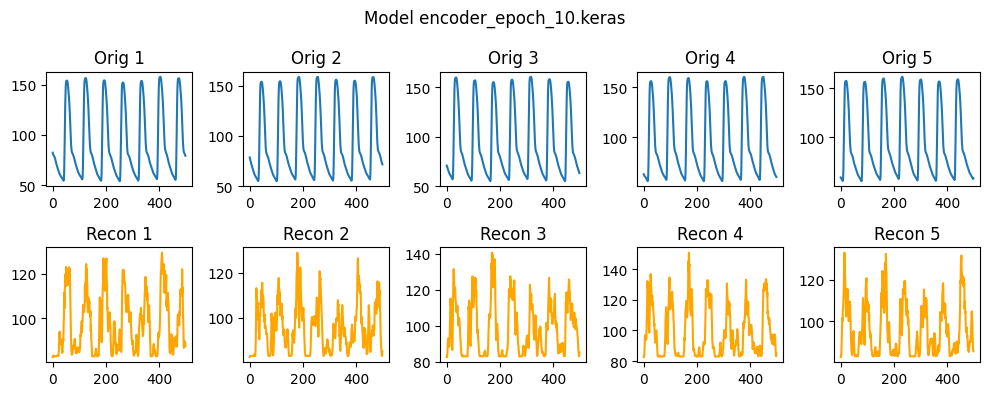

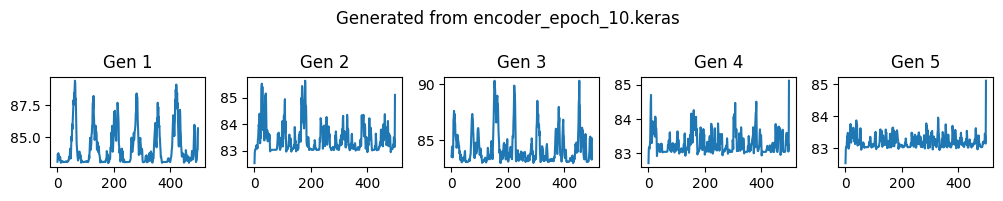

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_24']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


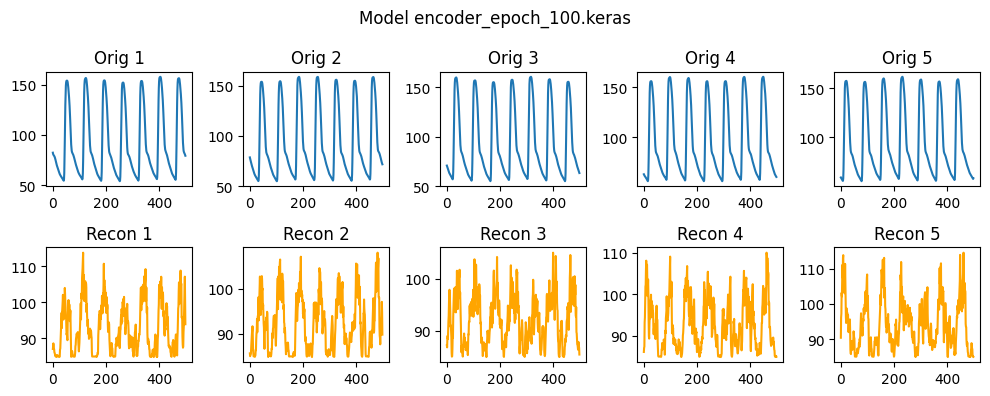

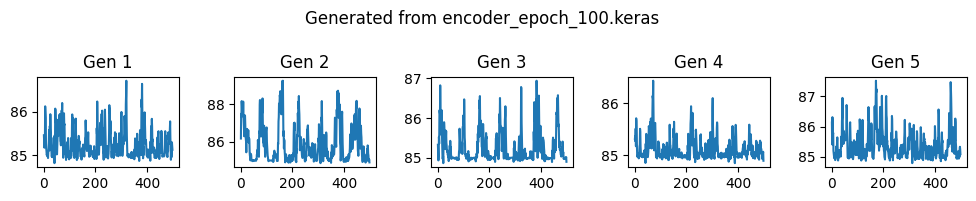

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_8']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


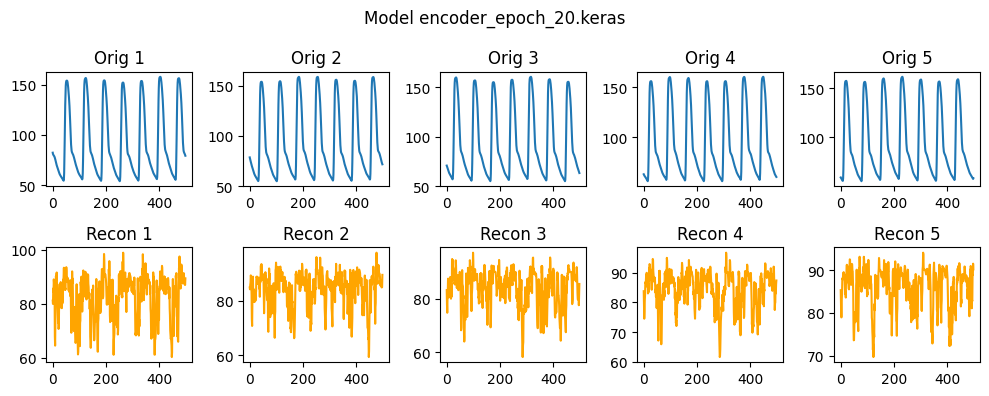

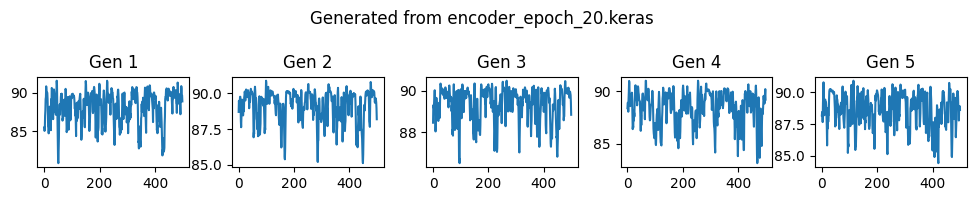

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


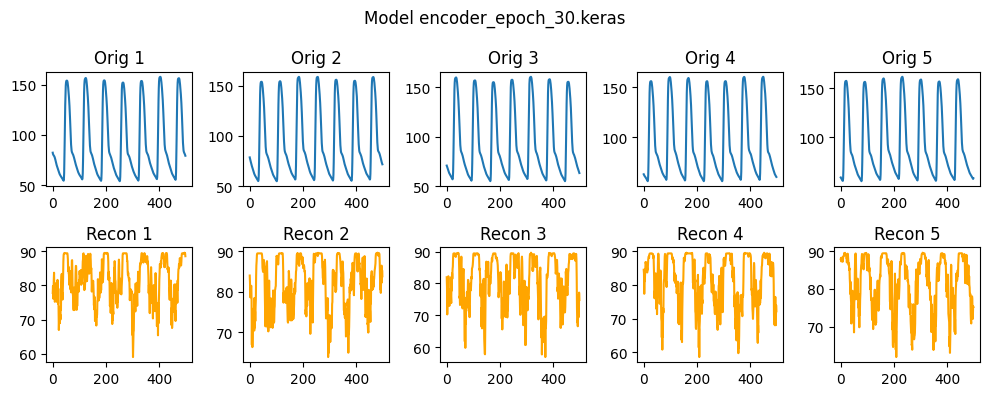

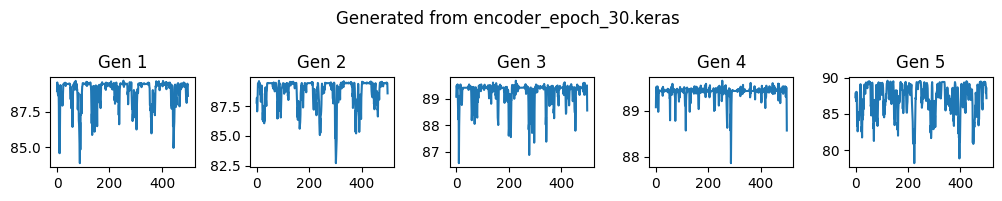

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_12']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


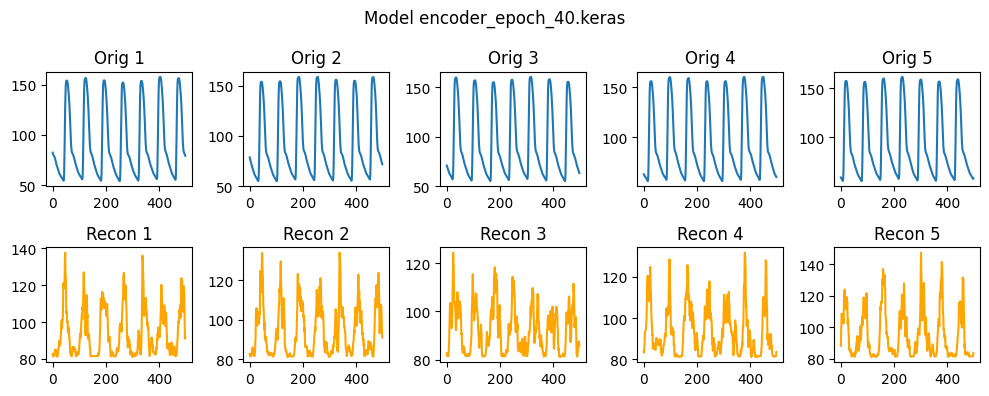

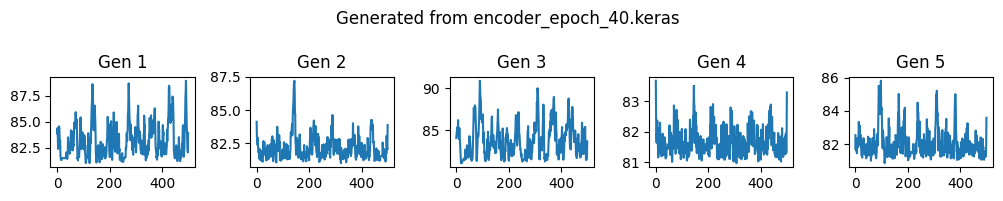

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_14']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


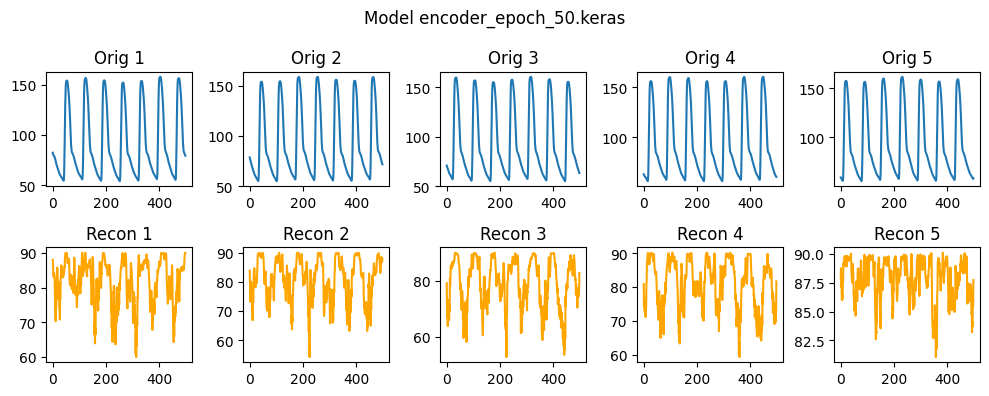

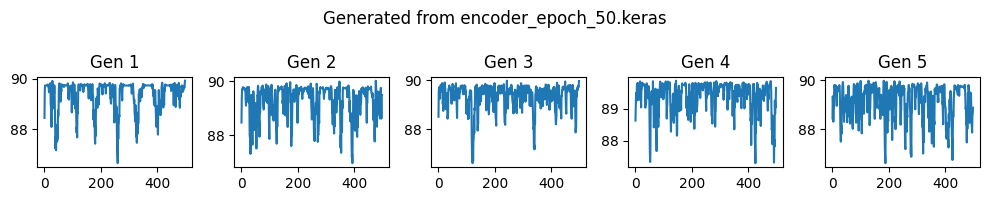

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_16']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


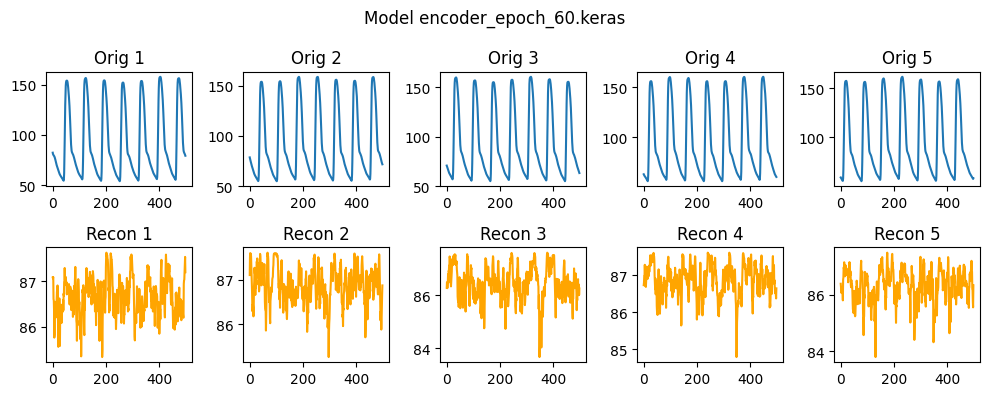

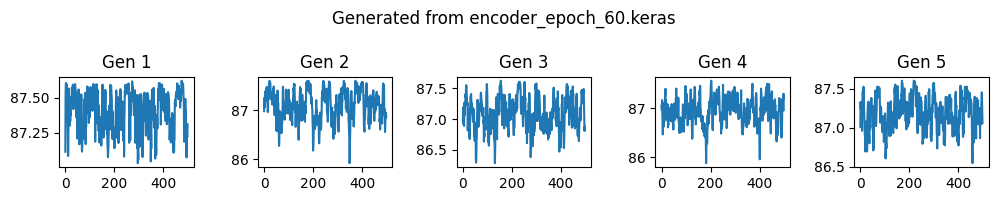

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_18']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


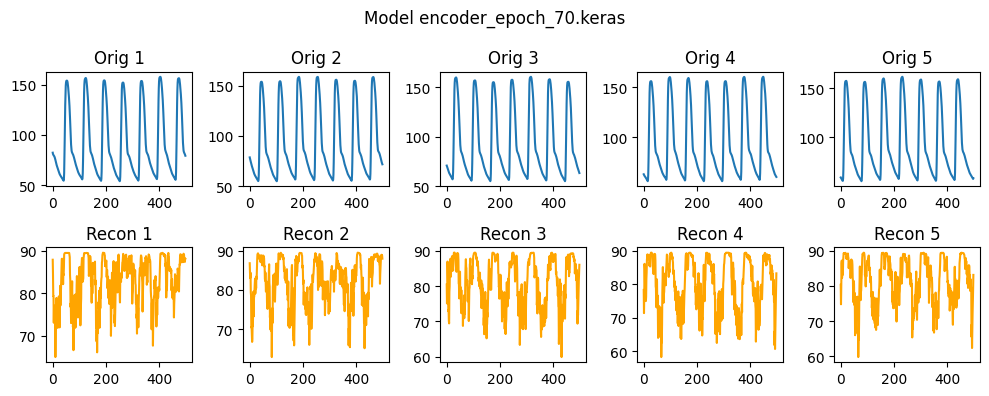

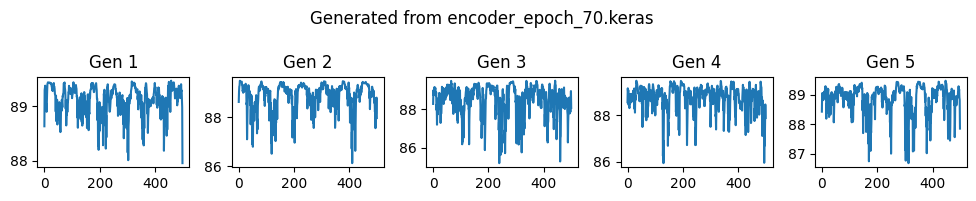

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_20']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


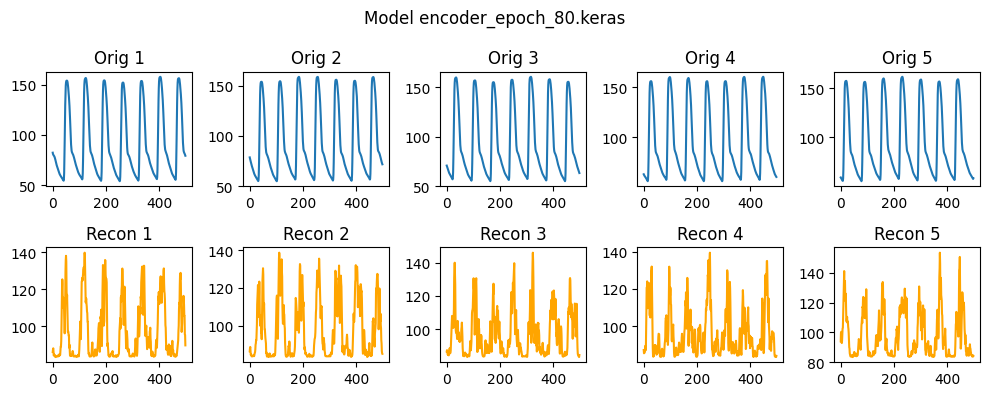

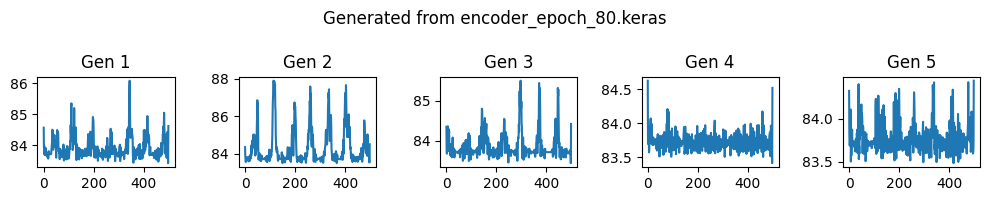

c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_22']
Received: inputs=Tensor(shape=(720, 500, 1))
  warnings.warn(msg)


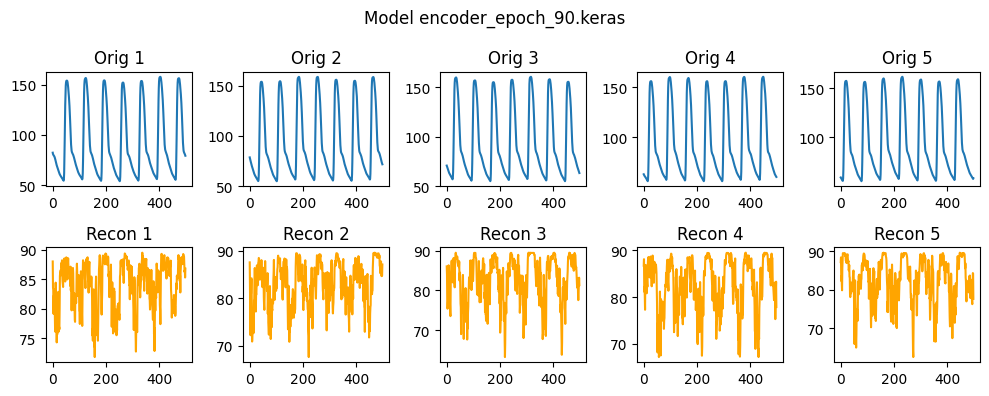

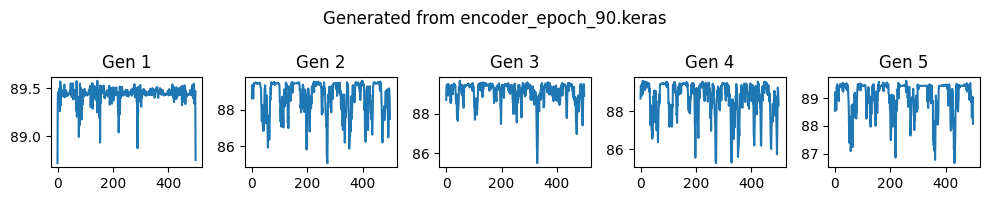

In [26]:
HDF5_PATH = "spectrum/spectra_analysis.hdf5"
GROUP_NAME = None
LATENT_DIM = 4
EPOCHS = 100
BATCH_SIZE = 32
BETA = 1e-3
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

def load_spectral_data(path, group_name=None):
    with h5py.File(path, "r") as f:
        if group_name is None:
            group_name = list(f.keys())[0]
        dataset = f[group_name]
        if isinstance(dataset, h5py.Group):
            dataset = dataset[list(dataset.keys())[0]]
        spectra = dataset[:]
    return spectra

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(4, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation="relu")(inputs)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(4, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv1D(1, 3, activation="linear", padding="same")(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

spectra = load_spectral_data(HDF5_PATH, group_name=GROUP_NAME)
spectra_expanded = spectra[..., np.newaxis]
scaler = StandardScaler()
data_flat = spectra_expanded.reshape(-1, 1)
data_scaled = scaler.fit_transform(data_flat).reshape(spectra_expanded.shape)
joblib.dump(scaler, SCALER_PATH)

for i in range(0, EPOCHS, 10):
    encoder = build_encoder((data_scaled.shape[1], 1), LATENT_DIM)
    decoder = build_decoder(LATENT_DIM, (data_scaled.shape[1], 1))
    vae = VAE(encoder, decoder, beta=BETA)
    vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    vae.fit(data_scaled, epochs=10, batch_size=BATCH_SIZE, verbose=0)
    encoder.save(os.path.join(MODEL_DIR, f"encoder_epoch_{i+10}.keras"))
    decoder.save(os.path.join(MODEL_DIR, f"decoder_epoch_{i+10}.keras"))

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

models = sorted(glob.glob(os.path.join(MODEL_DIR, "encoder_epoch_*.keras")))
scaler = joblib.load(SCALER_PATH)

for enc_path in models:
    dec_path = enc_path.replace("encoder", "decoder")
    encoder = load_model(enc_path, custom_objects={"Sampling": Sampling})
    decoder = load_model(dec_path)
    vae = VAE(encoder, decoder)

    reconstructed = decoder(encoder(data_scaled)[2]).numpy()
    recon_rescaled = scaler.inverse_transform(reconstructed.reshape(-1, 1)).reshape(reconstructed.shape)
    original_signals = spectra[:5]
    reconstructed_signals = recon_rescaled[:5, :, 0]

    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.plot(original_signals[i])
        plt.title(f"Orig {i+1}")
        plt.subplot(2, 5, i + 6)
        plt.plot(reconstructed_signals[i], color="orange")
        plt.title(f"Recon {i+1}")
    plt.suptitle(f"Model {os.path.basename(enc_path)}")
    plt.tight_layout()
    plt.show()

    random_latents = tf.random.normal((5, LATENT_DIM))
    generated_scaled = decoder(random_latents).numpy()
    generated_rescaled = scaler.inverse_transform(generated_scaled.reshape(-1, 1)).reshape(generated_scaled.shape)
    generated_signals = generated_rescaled[:, :, 0]

    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.plot(generated_signals[i])
        plt.title(f"Gen {i+1}")
    plt.suptitle(f"Generated from {os.path.basename(enc_path)}")
    plt.tight_layout()
    plt.show()


Epoch 1/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 7.8768 - loss: 0.7700 - recon_loss: 0.7622
Epoch 2/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 14.4020 - loss: 0.3054 - recon_loss: 0.2910
Epoch 3/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 12.4348 - loss: 0.1799 - recon_loss: 0.1675
Epoch 4/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 9.8156 - loss: 0.1383 - recon_loss: 0.1285
Epoch 5/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 8.3281 - loss: 0.1153 - recon_loss: 0.1070
Epoch 6/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 7.4407 - loss: 0.1005 - recon_loss: 0.0931
Epoch 7/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 6.8127 - loss: 0.0901 - recon_loss: 0.0833
Epoch 8/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 6.3342 - loss: 0.0822 - recon_loss: 0.0759
Epoch 9/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 5.9577 - loss: 0.0764 - recon_loss: 0.0704
Epoch 10/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 

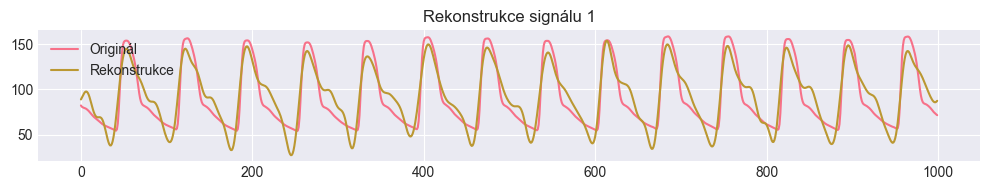

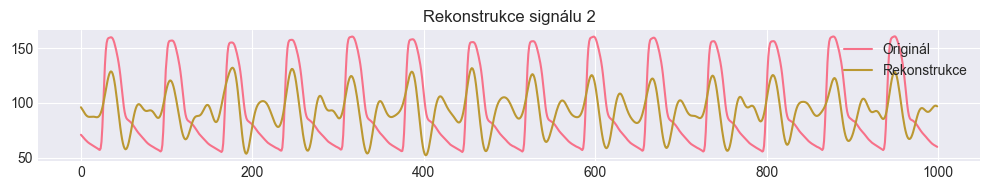

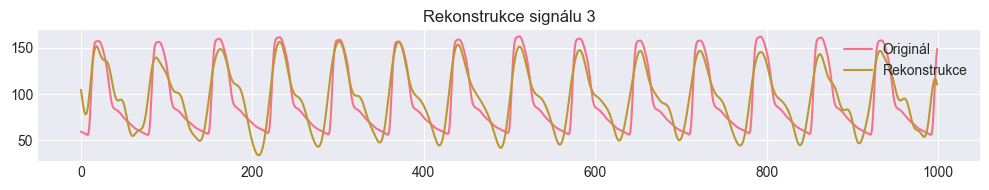

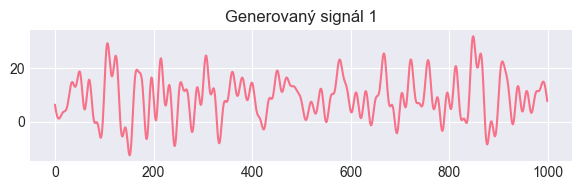

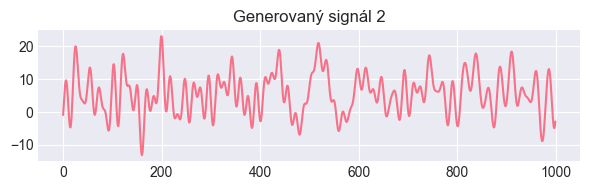

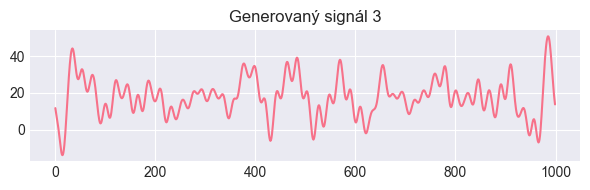

In [ ]:
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = 64
LATENT_DIM = 32
EPOCHS = 50
BATCH_SIZE = 32
BETA = 1e-3
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size, n_components):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            fft_cut = fft_vals[:n_components]
            spectrum = np.stack([fft_cut.real, fft_cut.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE, N_COMPONENTS)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(8, 3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(np.prod(output_shape), activation="linear")(x)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(8, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(output_shape[-1], 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            loss_recon = tf.reduce_mean(tf.square(data - recon))
            loss_kl = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            loss_total = loss_recon + self.beta * loss_kl
        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(loss_kl)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(X_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder.save(os.path.join(MODEL_DIR, "vae_encoder_rfft.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_rfft.keras"))

reconstructed = vae.decoder(vae.encoder(X_scaled)[2]).numpy()
reconstructed = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)

for i in range(3):
    re = reconstructed[i][:, 0]
    im = reconstructed[i][:, 1]
    spectrum = re + 1j * im
    recon_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(10, 2))
    plt.plot(originals[i], label="Originál")
    plt.plot(recon_time, label="Rekonstrukce")
    plt.title(f"Rekonstrukce signálu {i+1}")
    plt.legend()
    plt.tight_layout()
    plt.show()

random_latents = tf.random.normal((3, LATENT_DIM))
generated = decoder(random_latents).numpy()
generated = scaler.inverse_transform(generated.reshape(-1, 2)).reshape(generated.shape)

for i in range(3):
    re = generated[i][:, 0]
    im = generated[i][:, 1]
    spectrum = re + 1j * im
    gen_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(6, 2))
    plt.plot(gen_time)
    plt.title(f"Generovaný signál {i+1}")
    plt.tight_layout()
    plt.show()


Loading data from: data
Processing file: data\signals_2024-03-04\dataset_0\TBI_001_v2_1_2_20.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_001_v2_1_3_6.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_002_v4_2_5_5.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_002_v4_2_7_8.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_003_v2_2_1_0.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_003_v2_2_1_5.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_004b_v2_1_2_16.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_004b_v2_1_3_6.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_005_v2_2_2_19.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_007_v3_1_2_17.hdf5
Processing file: data\signals_2024-03-04\dataset_1\TBI_001_v2_1_2_5.hdf5
Processing file: data\signals_2024-03-04\dataset_1\TBI_002_v4_2_5_20.hdf5
Processing file: data\signals_2024-03-04\dataset_1\TBI_002_v4_2_7_6.hdf5
Processing file: dat

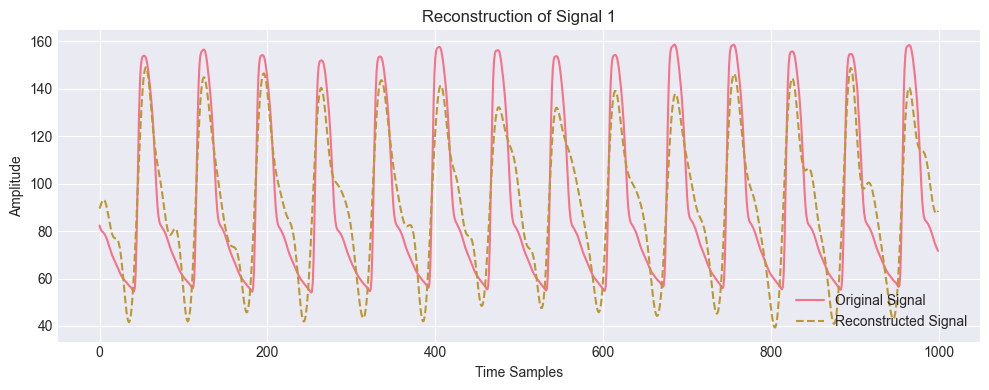

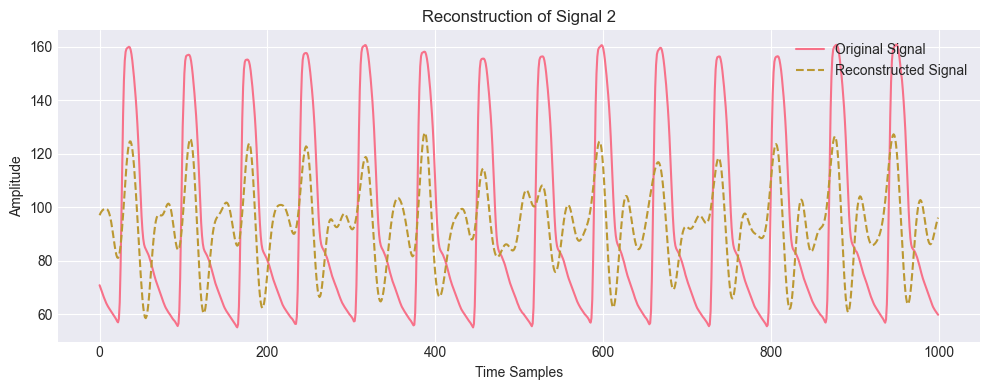

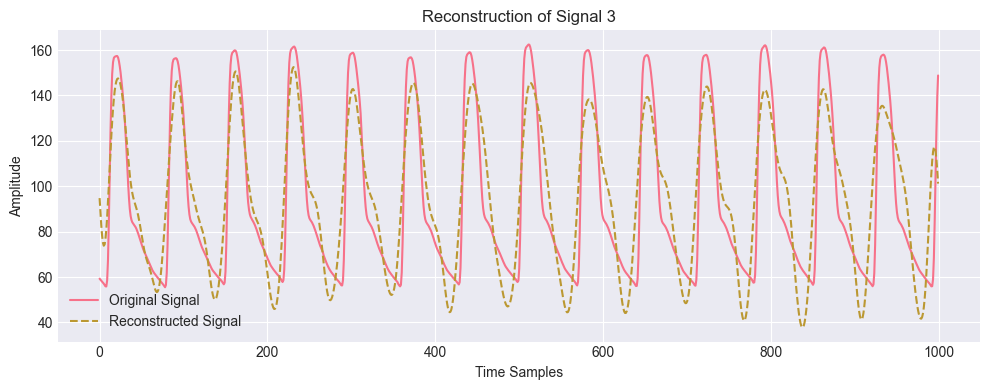


--- Generating New Samples ---


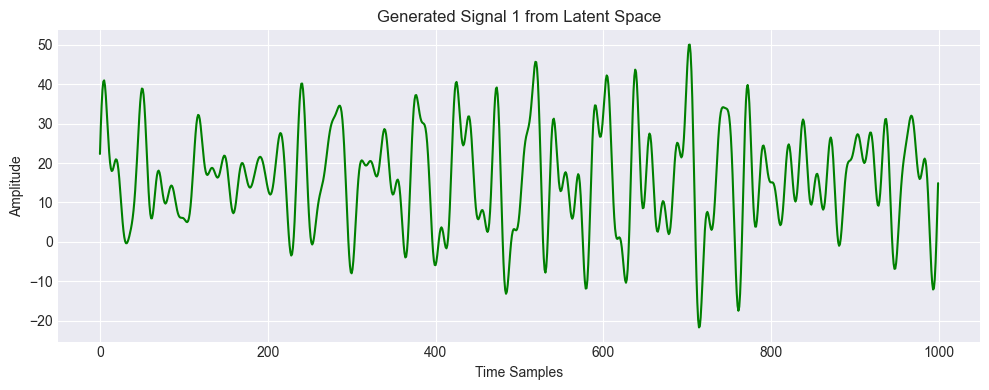

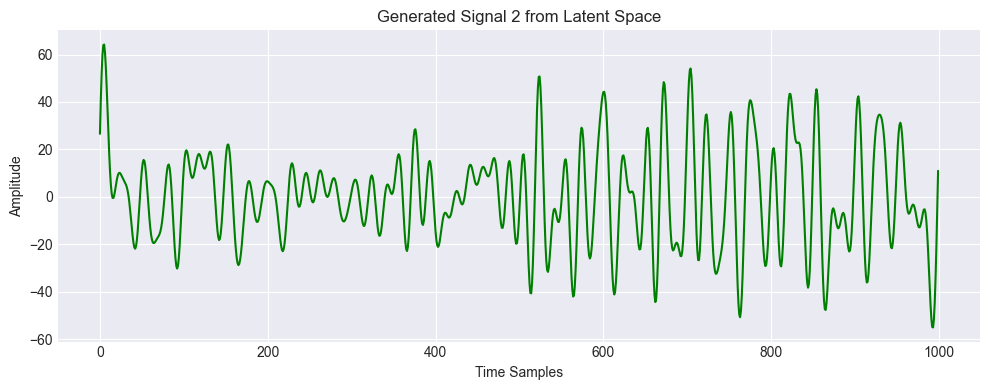

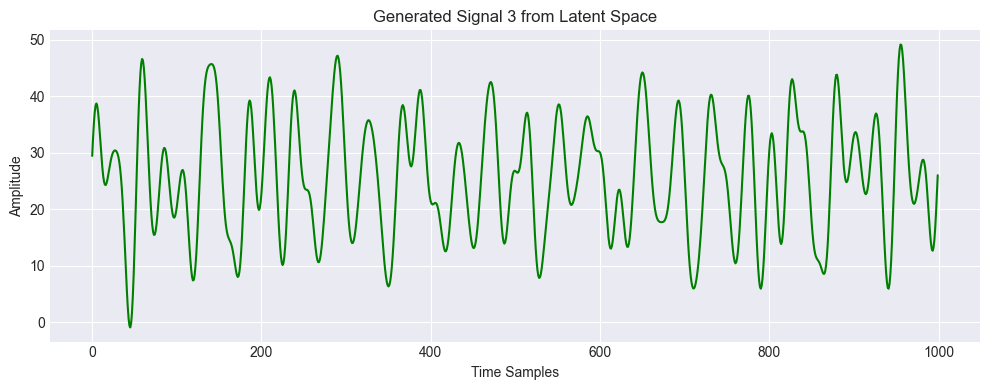


--- Script Finished ---


In [ ]:
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = 64
LATENT_DIM = 32
EPOCHS = 100
BATCH_SIZE = 64
BETA = 5e-4
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")

os.makedirs(MODEL_DIR, exist_ok=True)

def get_file_paths(folder_path):
    """
    Retrieves HDF5 file paths from a given folder using FolderExtractor.
    """
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    """
    Loads a specific signal from an HDF5 file, auto-annotates it,
    and extracts clean segments.
    """
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size, n_components):
    """
    Computes Real Fast Fourier Transform (RFFT) spectra from a signal
    in non-overlapping windows.
    """
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i : i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            fft_cut = fft_vals[:n_components]
            spectrum = np.stack([fft_cut.real, fft_cut.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

spectra_list, originals_list = [], []
print(f"Loading data from: {HDF_PATH}")
for path in get_file_paths(HDF_PATH):
    print(f"Processing file: {path}")
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        print(f"No clean signal found in {path}. Skipping.")
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE, N_COMPONENTS)
    if spec.size == 0:
        print(f"No valid spectra generated for {path}. Skipping.")
        continue
    spectra_list.append(spec)
    originals_list.append(orig)

if not spectra_list:
    raise ValueError("No data was loaded or processed. Please check your HDF_PATH and data files.")

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

print(f"Shape of raw spectra (X): {X.shape}")
print(f"Shape of original windows: {originals.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)
print(f"Scaler saved to: {SCALER_PATH}")
print(f"Shape of scaled spectra (X_scaled): {X_scaled.shape}")

class Sampling(layers.Layer):
    """
    Custom Keras layer for sampling from the latent space using the
    reparameterization trick.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    """
    Builds the encoder part of the VAE with increased capacity.
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv1D(16, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv1D(8, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling(name="z")([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    """
    Builds the decoder part of the VAE with increased capacity.
    """
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64)(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(np.prod(output_shape))(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape(output_shape)(x)

    x = layers.Conv1D(64, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv1D(32, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv1D(16, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    outputs = layers.Conv1D(output_shape[-1], 3, padding="same", activation="linear")(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    """
    Variational Autoencoder (VAE) model with Huber loss for reconstruction.
    """
    def __init__(self, encoder, decoder, beta=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        # Použití Huberovy ztráty místo MSE pro rekonstrukci
        self.recon_loss_fn = tf.keras.losses.Huber(delta=1.0, reduction=tf.keras.losses.Reduction.NONE)
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            # Výpočet Huberovy ztráty
            loss_recon = tf.reduce_mean(self.recon_loss_fn(data, recon))
            loss_kl = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            loss_total = loss_recon + self.beta * loss_kl

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(loss_kl)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

print("\n--- Starting VAE Training ---")
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(X_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder_save_path = os.path.join(MODEL_DIR, "vae_encoder_rfft.keras")
decoder_save_path = os.path.join(MODEL_DIR, "vae_decoder_rfft.keras")
encoder.save(encoder_save_path)
decoder.save(decoder_save_path)
print(f"Encoder saved to: {encoder_save_path}")
print(f"Decoder saved to: {decoder_save_path}")

print("\n--- Reconstructing Samples ---")
# Získání latentní reprezentace a rekonstrukce
_, _, z_reconstructed = vae.encoder(X_scaled)
reconstructed_spectra = vae.decoder(z_reconstructed).numpy()
reconstructed_spectra = scaler.inverse_transform(
    reconstructed_spectra.reshape(-1, 2)
).reshape(reconstructed_spectra.shape)

for i in range(3):
    re_recon = reconstructed_spectra[i][:, 0]
    im_recon = reconstructed_spectra[i][:, 1]
    spectrum_recon = re_recon + 1j * im_recon
    recon_time = np.fft.irfft(spectrum_recon, n=WINDOW_SIZE)

    plt.figure(figsize=(10, 4))
    plt.plot(originals[i], label="Original Signal")
    plt.plot(recon_time, label="Reconstructed Signal", linestyle='--')
    plt.title(f"Reconstruction of Signal {i+1}")
    plt.xlabel("Time Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Generating New Samples ---")
# Generování náhodných latentních vektorů a dekódování
random_latents = tf.random.normal((3, LATENT_DIM))
generated_spectra = decoder(random_latents).numpy()
# Inverzní transformace generovaného spektra
generated_spectra = scaler.inverse_transform(
    generated_spectra.reshape(-1, 2)
).reshape(generated_spectra.shape)

for i in range(3):
    re_gen = generated_spectra[i][:, 0]
    im_gen = generated_spectra[i][:, 1]
    spectrum_gen = re_gen + 1j * im_gen
    gen_time = np.fft.irfft(spectrum_gen, n=WINDOW_SIZE)

    plt.figure(figsize=(10, 4))
    plt.plot(gen_time, color='green')
    plt.title(f"Generated Signal {i+1} from Latent Space")
    plt.xlabel("Time Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Script Finished ---")

# Možná

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "icp"
WINDOW_SIZE = 500
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 100
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "modelpokusicp"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAHRANI A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

for epoch in range(1, EPOCHS + 1):
    print(f"Epocha: {epoch}")
    vae.fit(X_scaled, epochs=1, batch_size=BATCH_SIZE, verbose=0)
    if epoch % 10 == 0 or epoch == EPOCHS:
        encoder.save(os.path.join(MODEL_DIR, f"vae_encoder_epoch{epoch:03d}.keras"))
        decoder.save(os.path.join(MODEL_DIR, f"vae_decoder_epoch{epoch:03d}.keras"))

# === TESTOVÁNÍ MODELŮ ===
model_files = sorted(os.listdir(MODEL_DIR))
encoders = [f for f in model_files if f.startswith("vae_encoder_epoch")]
decoders = [f for f in model_files if f.startswith("vae_decoder_epoch")]
model_pairs = []
for enc_file in encoders:
    epoch = enc_file.replace("vae_encoder_epoch", "").replace(".keras", "")
    dec_file = f"vae_decoder_epoch{epoch}.keras"
    if dec_file in decoders:
        model_pairs.append((
            os.path.join(MODEL_DIR, enc_file),
            os.path.join(MODEL_DIR, dec_file),
            int(epoch)
        ))

# === VIZUALIZACE ===
for idx, (encoder_path, decoder_path, epoch) in enumerate(model_pairs):
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    sample = X_scaled[idx % len(X_scaled)][None, ...]
    original = originals[idx % len(originals)]

    z_mean, z_log_var, z = encoder.predict(sample)
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    recon_time *= np.max(np.abs(original)) / (np.max(np.abs(recon_time)) + 1e-8)

    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.title(f"Epoch {epoch} – Realita vs Rekonstrukce")
    plt.legend()
    plt.tight_layout()
    plt.show()

    for i in range(3):
        z_new = np.random.normal(size=z.shape)
        gen = decoder.predict(z_new)
        gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
        gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
        gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)
        gen_time *= np.max(np.abs(original)) / (np.max(np.abs(gen_time)) + 1e-8)

        plt.figure(figsize=(12, 2))
        plt.plot(gen_time)
        plt.title(f"Epoch {epoch} – Generace {i+1}")
        plt.tight_layout()
        plt.show()
